<a href="https://colab.research.google.com/github/matteo4diani/federated-survival-analysis/blob/main/federated_survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [3]:
!pip install memory_profiler
!pip install seaborn
!pip install torch
!pip install tensorboard
!pip install flower
!pip install scikit-learn
!pip install scikit-survival
!pip install --upgrade ipython


# Clone PyTorch/StableBaselines wrappers
!git clone https://github.com/matteo4diani/federated-survival-analysis-utils.git
     

# Put the downloaded repo on path so we can import custom libraries into Colab
import sys
sys.path.insert(0,'/content/federated-survival-analysis-utils')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.8/775.8 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 KB 37.6 MB/s eta 0:00:00
  Attempting uninstall: prompt-toolkit
    Found existing installa

# Imports and Utilities

In [97]:
from IPython.display import display, HTML

from sksurv.datasets import load_veterans_lung_cancer
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sksurv.preprocessing import OneHotEncoder
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import concordance_index_ipcw
from sksurv.metrics import as_concordance_index_ipcw_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

def get_ordinal_from_categorical(dataframe, column_name):
  encoder = OrdinalEncoder()
  transform = encoder.fit_transform(np.asarray(dataframe[column_name])[:, None])
  return pd.DataFrame({f'{column_name}_ordinal': pd.Series(np.squeeze(transform))})

# Load data

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


[( True,  72.) ( True, 411.) ( True, 228.) ( True, 126.) ( True, 118.)
 ( True,  10.) ( True,  82.) ( True, 110.) ( True, 314.) (False, 100.)
 ( True,  42.) ( True,   8.) ( True, 144.) (False,  25.) ( True,  11.)
 ( True,  30.) ( True, 384.) ( True,   4.) ( True,  54.) ( True,  13.)
 (False, 123.) (False,  97.) ( True, 153.) ( True,  59.) ( True, 117.)
 ( True,  16.) ( True, 151.) ( True,  22.) ( True,  56.) ( True,  21.)
 ( True,  18.) ( True, 139.) ( True,  20.) ( True,  31.) ( True,  52.)
 ( True, 287.) ( True,  18.) ( True,  51.) ( True, 122.) ( True,  27.)
 ( True,  54.) ( True,   7.) ( True,  63.) ( True, 392.) ( True,  10.)
 ( True,   8.) ( True,  92.) ( True,  35.) ( True, 117.) ( True, 132.)
 ( True,  12.) ( True, 162.) ( True,   3.) ( True,  95.) ( True, 177.)
 ( True, 162.) ( True, 216.) ( True, 553.) ( True, 278.) ( True,  12.)
 ( True, 260.) ( True, 200.) ( True, 156.) (False, 182.) ( True, 143.)
 ( True, 105.) ( True, 103.) ( True, 250.) ( True, 100.) ( True, 999.)
 ( Tru

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


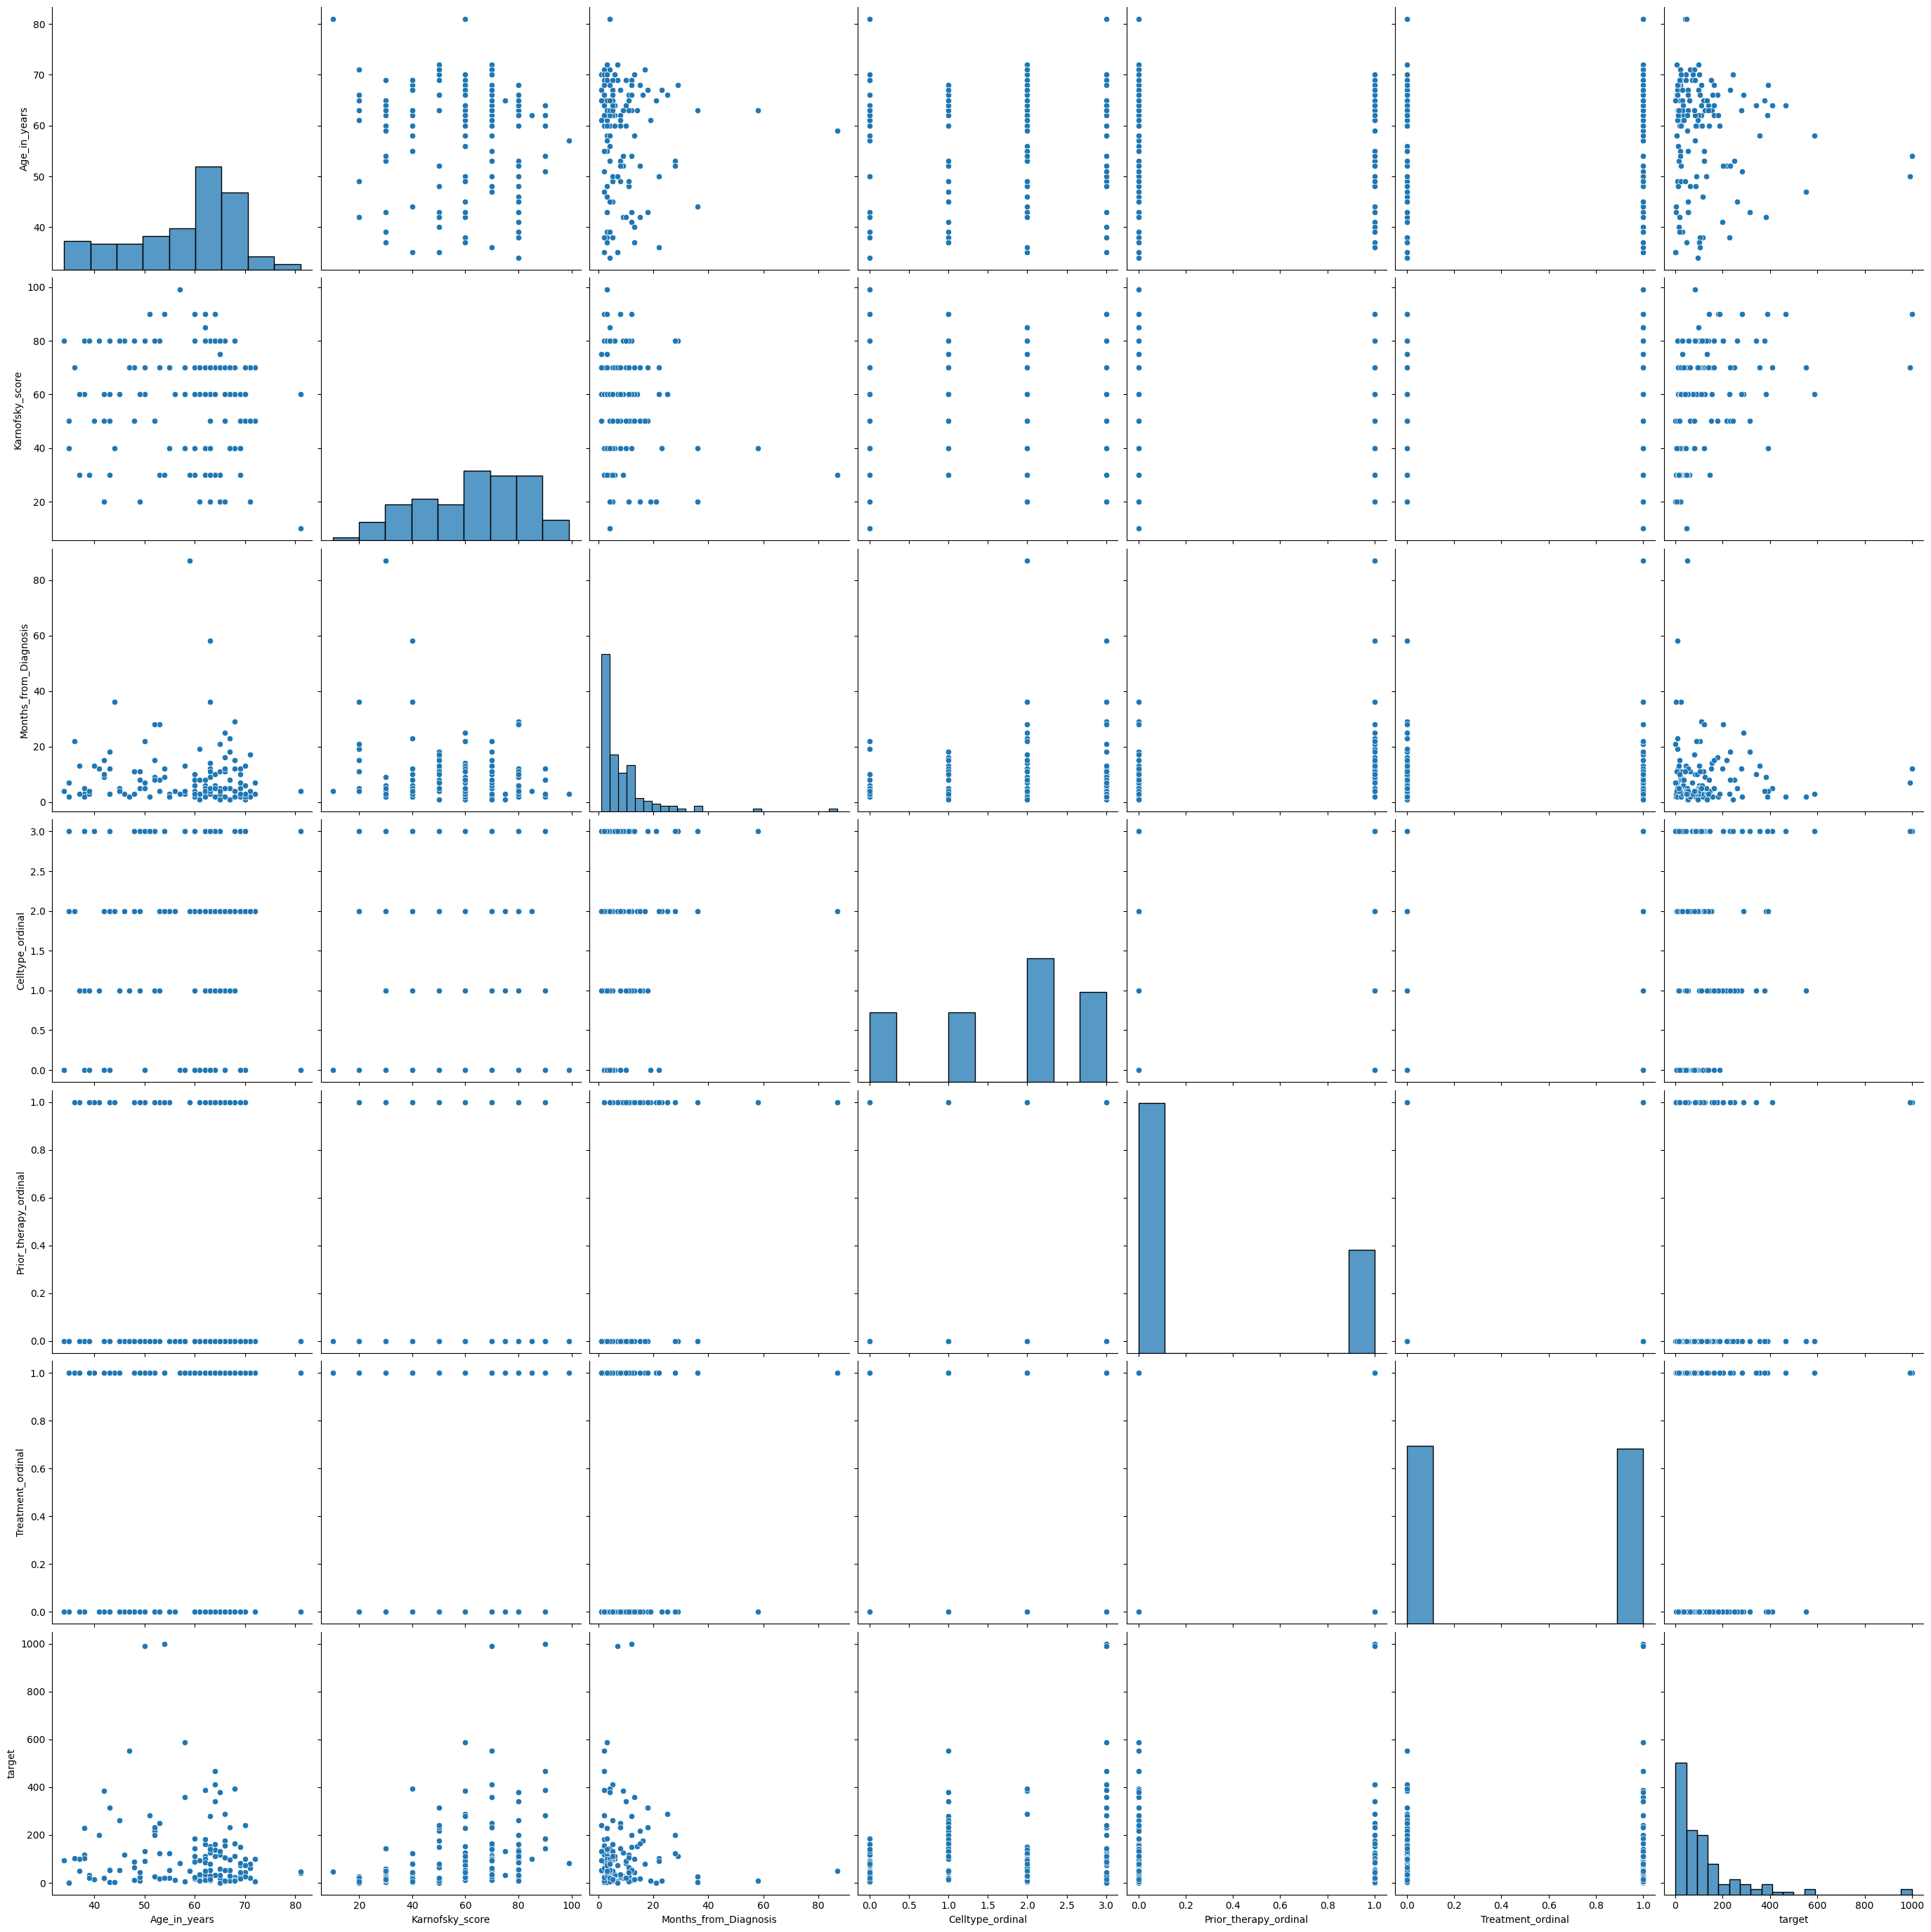

In [99]:
data_x, data_y = load_veterans_lung_cancer()

display(data_x)
print(data_y)

data_y_dict = {'target': pd.Series(map(lambda y: y[1], data_y))}

data_celltype = get_ordinal_from_categorical(data_x, 'Celltype')
data_priortherapy = get_ordinal_from_categorical(data_x, 'Prior_therapy')
data_treatment = get_ordinal_from_categorical(data_x, 'Treatment')

data_df = pd.DataFrame({**data_x.to_dict(),
                        **data_celltype.to_dict(), 
                        **data_priortherapy.to_dict(), 
                        **data_treatment.to_dict(), 
                        **data_y_dict})

sns.pairplot(data_df,
             diag_kind='hist',
             size = 4)

# Kaplan-Meier Survival Estimates

Text(0.5, 0, 'time $t$')

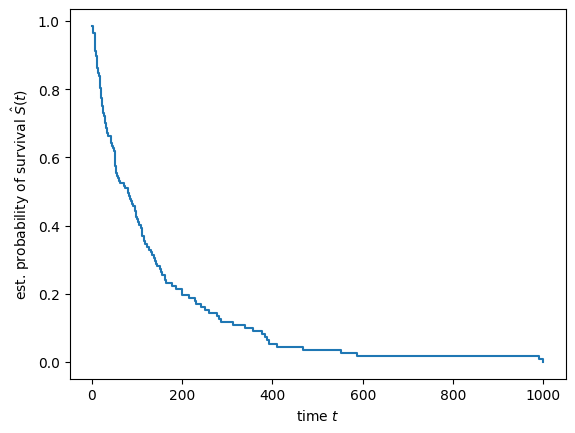

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## Survival Functions by Treatment

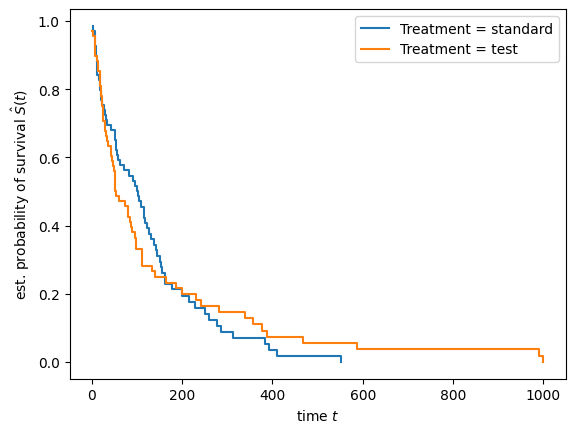

In [64]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Survival Functions by Cell Type

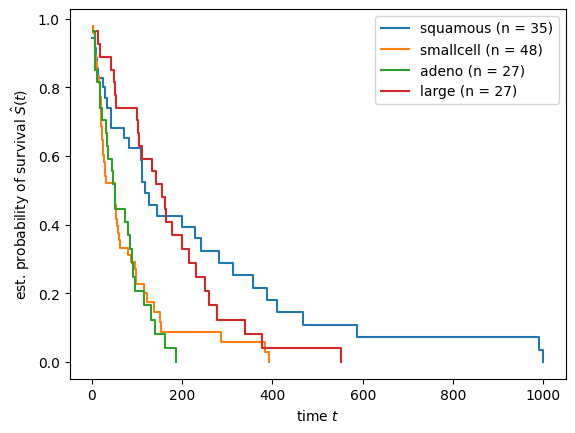

In [65]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Cox's Proportional Hazard Model

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


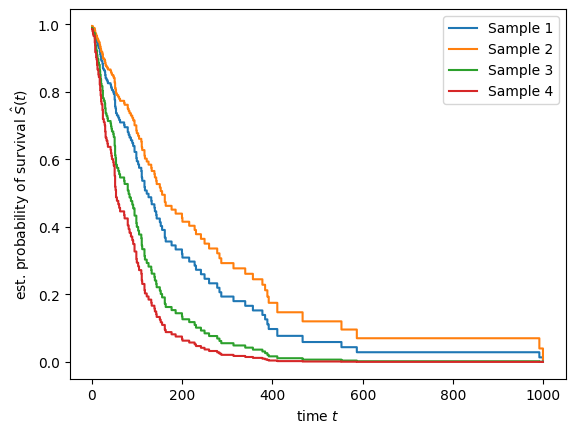

In [100]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)
display(data_x_numeric.head())

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

display(pd.Series(estimator.coef_, index=data_x_numeric.columns))

x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=data_x_numeric.columns, orient='index')

display(x_new)

pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Performance Measures



## Harrell's Concordance Index

Harrell's Concordance Index is a generalization of the area under the ROC curve measure, 1 denotes a perfect model, 0.5 a random model, and 0 a perfectly wrong model.

In [101]:

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)

print(result[0])

assert result[0] == estimator.score(data_x_numeric, data_y)

0.7362562471603816


## Alternative Measures

HCI can be biased in cases with high censoring. We can use  `concordance_index_ipcw`.

In [103]:
alternative_estimator = as_concordance_index_ipcw_scorer(CoxPHSurvivalAnalysis())
alternative_estimator.fit(data_x_numeric, data_y)

prediction = alternative_estimator.predict(data_x_numeric)

print(alternative_estimator.score(data_x_numeric, data_y))

assert result[0] > alternative_estimator.score(data_x_numeric, data_y)

0.728339023467177


# Feature Selection

In [104]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values,
                                data_y)

display(pd.Series(scores,
                index=data_x_numeric.columns).sort_values(ascending=False))

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score',
                                                    ascending=False)

display(results.loc[:, ~results.columns.str.endswith("_time")])

pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]

display(pd.Series(final_estimator.coef_,
                index=encoder.encoded_columns_[transformer.get_support()]))

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.716093,0.719862,0.716685,0.717547,0.001655,1,0.732087,0.742432,0.731710,0.735410,0.004968
3,4,{'select__k': 4},0.697368,0.722332,0.727324,0.715675,0.013104,2,0.732477,0.743090,0.727138,0.734235,0.006630
7,8,{'select__k': 8},0.706478,0.723320,0.716685,0.715494,0.006927,3,0.739356,0.746249,0.737519,0.741041,0.003758
5,6,{'select__k': 6},0.704453,0.719368,0.716685,0.713502,0.006491,4,0.735722,0.747565,0.731710,0.738332,0.006731
6,7,{'select__k': 7},0.700405,0.719368,0.720045,0.713272,0.009103,5,0.741173,0.742564,0.728621,0.737453,0.006271
1,2,{'select__k': 2},0.699393,0.717885,0.718365,0.711881,0.008833,6,0.732087,0.727428,0.714409,0.724642,0.007481
0,1,{'select__k': 1},0.698887,0.707510,0.712206,0.706201,0.005516,7,0.710670,0.714793,0.700445,0.708636,0.006032
2,3,{'select__k': 3},0.708502,0.714427,0.694849,0.705926,0.008198,8,0.734034,0.722559,0.716634,0.724409,0.007223


Celltype=large       -0.754714
Celltype=smallcell   -0.328059
Celltype=squamous    -1.147673
Karnofsky_score      -0.031112
Treatment=test        0.257313
dtype: float64